# Make mutation frequency plot

In [74]:
import os
import pandas as pd
import numpy as np
from Bio import Seq, SeqIO
from collections import Counter
from matplotlib import cm
from matplotlib import colors
import matplotlib.patches as mpatches
import multiprocessing as mp
import matplotlib.image as image
from matplotlib import ticker
%matplotlib notebook

In [263]:
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
cj_plasmid = [seq for seq in SeqIO.parse('Cj_plasmid.fna', 'fasta')][0]

In [3]:
start = 150
end = 3213

In [4]:
protein_seq = cj_plasmid[start:end].translate().seq
protein_seq

Seq('MGKPIPNPLLGLDSTSPKKKRKVEASARILAFDIGISSIGWAFSENDELKDCGV...AS*')

In [9]:
data = {f:pd.read_csv('CjCas9_round_{}.pileup'.format(f), sep='\t') for f in ['4']}

In [115]:
aa_substitutions_freqs = {}
for f in data:
    aa_substitutions_freqs[f] = {}
    for i in data[f][1:].index:
        pos = data[f].loc[i, 'pos']-1 # pileup is 1-indexed
        original_aa = str(protein_seq[(pos-start)//3])
        aa_pos = (pos-start)//3 + 1 # positions of mutations are 1-indexed
        for base in ['A', 'C', 'T', 'G']:
            new_nucl_seq = cj_plasmid.seq[start:pos] + base + cj_plasmid.seq[pos+1:end]
            new_prot_seq = new_nucl_seq.translate()
            new_aa = str(new_prot_seq[(pos-start)//3])
            aa_sub_name = original_aa + str(aa_pos) + new_aa
            nt_sub_name = data[f].loc[i, 'ref'] + str(pos) + base
            aa_substitutions_freqs[f][nt_sub_name] = [aa_sub_name, aa_pos, data[f].loc[i, base], pos]

In [116]:
for f in aa_substitutions_freqs:
    aa_substitutions_freqs[f] = pd.DataFrame(aa_substitutions_freqs[f]).transpose()
    aa_substitutions_freqs[f].columns = ['aa_sub', 'aa_pos', 'count', 'nt_pos']

In [117]:
for f in aa_substitutions_freqs:
    aa_substitutions_freqs[f] = aa_substitutions_freqs[f].groupby(['nt_pos', 'aa_pos', 'aa_sub'])[
        'count'].sum().reset_index()

In [119]:
cov_by_nt_pos = {f:aa_substitutions_freqs[f].groupby('nt_pos')['count'].sum() for f in aa_substitutions_freqs}

In [120]:
for f in aa_substitutions_freqs:
    aa_substitutions_freqs[f] = aa_substitutions_freqs[f].assign(freq=[aa_substitutions_freqs[f].loc[
        i, 'count']/cov_by_nt_pos[f].loc[aa_substitutions_freqs[f].loc[i, 'nt_pos']]
        for i in aa_substitutions_freqs[f].index])

In [122]:
for f in aa_substitutions_freqs:
    aa_substitutions_freqs[f] = aa_substitutions_freqs[f].assign(syn=[mut[0]==mut[-1]
        for mut in aa_substitutions_freqs[f]['aa_sub'].values])

In [183]:
aa_substitutions_freqs = {f:aa_substitutions_freqs[f][[x not in range(2,26) and x<1020-11
    for x in aa_substitutions_freqs[f]['aa_pos'].values]] for f in aa_substitutions_freqs}

In [191]:
to_plot = {f:aa_substitutions_freqs[f][~aa_substitutions_freqs[f]['syn']].groupby('aa_pos')[
    'freq'].sum().reset_index(drop=True) for f in aa_substitutions_freqs}

In [195]:
for f in to_plot:
    to_plot[f].index = [i+1 for i in to_plot[f].index]

<IPython.core.display.Javascript object>


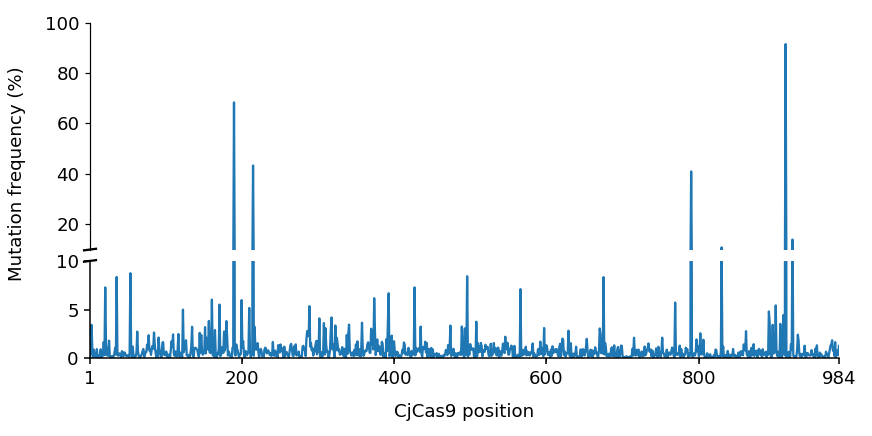

In [266]:
fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), sharex=True, gridspec_kw={'height_ratios': [7,3]})

(to_plot['4']*100).plot(ax=ax1)
(to_plot['4']*100).plot(ax=ax2)

ax2.set_ylim(0,10)
ax1.set_ylim(10,100)

for y in ax1.get_yticklabels():
    y.set_size(12)
for y in ax2.get_yticklabels():
    y.set_size(12)

ax1.spines['bottom'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .008  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-3/7*d, +3/7*d), **kwargs)        # top-left diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

ax2.set_xticks([1,200,400,600,800,984])
for x in ax2.get_xticklabels():
    x.set_size(12)
ax1.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_linewidth(1)
ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_linewidth(1)
ax2.tick_params(width=1, length=4)
ax1.xaxis.set_ticks_position('none') 

ax1.set_xlim(1,984)
ax2.set_xlim(1,984)

ax2.set_xlabel('CjCas9 position', size=12, labelpad=10)
ax2.set_ylabel('Mutation frequency (%)', size=12, labelpad=15, color='white')

fig.text(0.02, 0.6, 'Mutation frequency (%)', ha='center', va='center', rotation='vertical', size=12)
    

plt.tight_layout()
plt.subplots_adjust(hspace=0.07)
plt.savefig('pileup_plot/Cj_mutations_2.svg')
plt.show()